### Boosting is a sequential technique which works on the principle of ensemble. It combines a set of weak learners and delivers improved prediction accuracy. At any instant t, the model outcomes are weighed based on the outcomes of previous instant t-1. The outcomes predicted correctly are given a lower weight and the ones miss-classified are weighted higher. This technique is followed for a classification problem while a similar technique is used for regression.



* Tree-Specific Parameters: These affect each individual tree in the model.
* Boosting Parameters: These affect the boosting operation in the model.
* Miscellaneous Parameters: Other parameters for overall functioning.

### Tree parameters

#### min_samples_split
Defines the minimum number of samples (or observations) which are required in a node to be considered for splitting.
Used to control over-fitting. Higher values prevent a model from learning relations which might be highly specific to the particular sample selected for a tree.
Too high values can lead to under-fitting hence, it should be tuned using CV.
#### min_samples_leaf
Defines the minimum samples (or observations) required in a terminal node or leaf.
Used to control over-fitting similar to min_samples_split.
Generally lower values should be chosen for imbalanced class problems because the regions in which the minority class will be in majority will be very small.
#### min_weight_fraction_leaf
Similar to min_samples_leaf but defined as a fraction of the total number of observations instead of an integer.
Only one of #2 and #3 should be defined.
#### max_depth
The maximum depth of a tree.
Used to control over-fitting as higher depth will allow model to learn relations very specific to a particular sample.
Should be tuned using CV.
#### max_leaf_nodes
The maximum number of terminal nodes or leaves in a tree.
Can be defined in place of max_depth. Since binary trees are created, a depth of ‘n’ would produce a maximum of 2^n leaves.
If this is defined, GBM will ignore max_depth.
#### max_features
The number of features to consider while searching for a best split. These will be randomly selected.
As a thumb-rule, square root of the total number of features works great but we should check upto 30-40% of the total number of features.
Higher values can lead to over-fitting but depends on case to case.


### Boosting Parameters

#### learning_rate
This determines the impact of each tree on the final outcome (step 2.4). GBM works by starting with an initial estimate which is updated using the output of each tree. The learning parameter controls the magnitude of this change in the estimates.
Lower values are generally preferred as they make the model robust to the specific characteristics of tree and thus allowing it to generalize well.
Lower values would require higher number of trees to model all the relations and will be computationally expensive.
#### n_estimators
The number of sequential trees to be modeled
Though GBM is fairly robust at higher number of trees but it can still overfit at a point. Hence, this should be tuned using CV for a particular learning rate.
#### subsample
The fraction of observations to be selected for each tree. Selection is done by random sampling.
Values slightly less than 1 make the model robust by reducing the variance.
Typical values ~0.8 generally work fine but can be fine-tuned further.

### Misc parameters

#### loss
It refers to the loss function to be minimized in each split.
It can have various values for classification and regression case. Generally the default values work fine. Other values should be chosen only if you understand their impact on the model.
#### init
This affects initialization of the output.
This can be used if we have made another model whose outcome is to be used as the initial estimates for GBM.
#### random_state
The random number seed so that same random numbers are generated every time.
This is important for parameter tuning. If we don’t fix the random number, then we’ll have different outcomes for subsequent runs on the same parameters and it becomes difficult to compare models.
It can potentially result in overfitting to a particular random sample selected. We can try running models for different random samples, which is computationally expensive and generally not used.
#### verbose
The type of output to be printed when the model fits. The different values can be:
0: no output generated (default)
1: output generated for trees in certain intervals
greater than 1: output generated for all trees


In [1]:
#Import libraries:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier  #GBM algorithm
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

/home/pankaj/.local/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/pankaj/.local/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [35]:
train = pd.read_csv('train_modified.csv', encoding = "ISO-8859-1")
target = 'Disbursed'
IDcol = 'ID'

In [36]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87020 entries, 0 to 87019
Data columns (total 51 columns):
Disbursed                        87020 non-null float64
Existing_EMI                     87020 non-null float64
ID                               87020 non-null object
Loan_Amount_Applied              87020 non-null float64
Loan_Tenure_Applied              87020 non-null float64
Monthly_Income                   87020 non-null int64
Var4                             87020 non-null int64
Var5                             87020 non-null int64
Age                              87020 non-null int64
EMI_Loan_Submitted_Missing       87020 non-null int64
Interest_Rate_Missing            87020 non-null int64
Loan_Amount_Submitted_Missing    87020 non-null int64
Loan_Tenure_Submitted_Missing    87020 non-null int64
Processing_Fee_Missing           87020 non-null int64
Device_Type_0                    87020 non-null int64
Device_Type_1                    87020 non-null int64
Filled_Form_0     

In [37]:
train.head()

,Disbursed,Existing_EMI,ID,Loan_Amount_Applied,Loan_Tenure_Applied,Monthly_Income,Var4,Var5,Age,EMI_Loan_Submitted_Missing,...,Var2_2,Var2_3,Var2_4,Var2_5,Var2_6,Mobile_Verified_0,Mobile_Verified_1,Source_0,Source_1,Source_2
0,0.0,0.0,ID000002C20,300000.0,5.0,20000,1,0,37,1,...,0,0,0,0,1,1,0,1,0,0
1,0.0,0.0,ID000004E40,200000.0,2.0,35000,3,13,30,0,...,0,0,0,0,1,0,1,1,0,0
2,0.0,0.0,ID000007H20,600000.0,4.0,22500,1,0,34,1,...,0,0,0,0,0,0,1,0,0,1
3,0.0,0.0,ID000008I30,1000000.0,5.0,35000,3,10,28,1,...,0,0,0,0,0,0,1,0,0,1
4,0.0,25000.0,ID000009J40,500000.0,2.0,100000,3,17,31,1,...,0,0,0,0,0,0,1,0,0,1


In [38]:
X_train=train
## drop ID column and target column
X_train = X_train.drop('ID',axis=1)
X_train = X_train.drop('Disbursed',axis=1)
Y_train = train['Disbursed']

In [39]:
from sklearn.cross_validation import train_test_split
train_x, test_x, train_y, test_y = train_test_split(X_train, Y_train, test_size=0.3, random_state=42)

In [49]:
def modelfit(alg, train_x, train_y,test_x,test_y, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(train_x, train_y)
        
    #Predict training set:
    dtrain_predictions = alg.predict(test_x)
    dtrain_predprob = alg.predict_proba(test_x)[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_validation.cross_val_score(alg, train_x, train_y, cv=cv_folds, scoring='roc_auc',verbose=1)
    
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(test_y, dtrain_predictions))
    print ("AUC Score (Test): %f" % metrics.roc_auc_score(test_y, dtrain_predprob))
    
    if performCV:
        print ("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
    
    predictors = [x for x in test_x.columns]
    
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   52.0s finished



Model Report
Accuracy : 0.9846
AUC Score (Test): 0.821899
CV Score : Mean - 0.8371007 | Std - 0.01030502 | Min - 0.8240823 | Max - 0.8496144


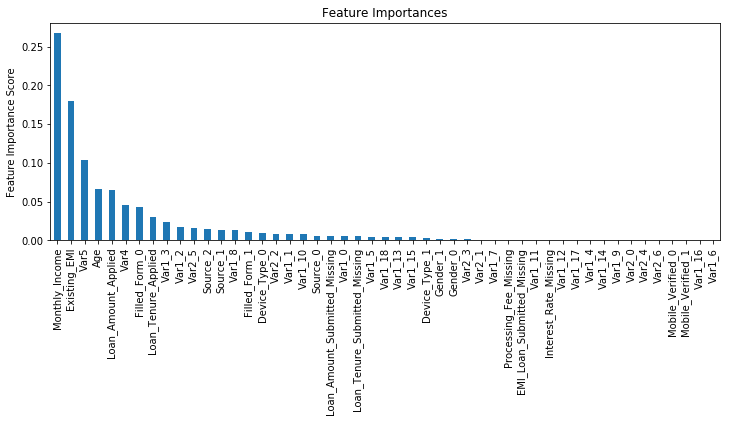

In [50]:
gbm0 = GradientBoostingClassifier(random_state=10)
modelfit(gbm0, train_x, train_y, test_x, test_y)

#### tuning boost parameters (n_estimators)

In [54]:
#Choose all predictors except target & IDcols
#predictors = [x for x in train.columns if x not in [target, IDcol]]
param_test1 = {'n_estimators':[20,30,40,50,60,70,80]}

gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, 
           min_samples_split=500,min_samples_leaf=50,max_depth=8,max_features='sqrt',
           subsample=0.8,random_state=10), param_grid = param_test1, scoring='roc_auc',
           n_jobs=4,iid=False, cv=5, verbose=1)

gsearch1.fit(train_x,train_y)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=4)]: Done  35 out of  35 | elapsed:  1.3min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=8,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=50,
              min_samples_split=500, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=10,
              subsample=0.8, verbose=0, warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'n_estimators': [20, 30, 40, 50, 60, 70, 80]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=1)

In [57]:
print(gsearch1.grid_scores_)
print(gsearch1.best_params_)
print(gsearch1.best_score_)

[mean: 0.83409, std: 0.01314, params: {'n_estimators': 20}, mean: 0.83562, std: 0.01331, params: {'n_estimators': 30}, mean: 0.83641, std: 0.01338, params: {'n_estimators': 40}, mean: 0.83735, std: 0.01348, params: {'n_estimators': 50}, mean: 0.83828, std: 0.01270, params: {'n_estimators': 60}, mean: 0.83852, std: 0.01382, params: {'n_estimators': 70}, mean: 0.83866, std: 0.01379, params: {'n_estimators': 80}]
{'n_estimators': 80}
0.838661805234825


#### tuning tree-specific parameters ( max_depth and num_samples_split, min_samples_leaf,  max_features)

In [64]:
param_test2 = {'max_depth':[5,7,9,11,13,15], 
               'min_samples_split':[200,400,600,800,1000]}

gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=80, 
           max_features='sqrt', subsample=0.8, random_state=10), 
           param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5,verbose=1)

gsearch2.fit(train_x,train_y)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed: 10.8min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=80, presort='auto', random_state=10,
              subsample=0.8, verbose=0, warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'min_samples_split': [200, 400, 600, 800, 1000], 'max_depth': [5, 7, 9, 11, 13, 15]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=1)

In [66]:
print(gsearch2.grid_scores_)
print(gsearch2.best_params_)
print(gsearch2.best_score_)

[mean: 0.84022, std: 0.01093, params: {'min_samples_split': 200, 'max_depth': 5}, mean: 0.83991, std: 0.01102, params: {'min_samples_split': 400, 'max_depth': 5}, mean: 0.84088, std: 0.01124, params: {'min_samples_split': 600, 'max_depth': 5}, mean: 0.83874, std: 0.01142, params: {'min_samples_split': 800, 'max_depth': 5}, mean: 0.84099, std: 0.01202, params: {'min_samples_split': 1000, 'max_depth': 5}, mean: 0.83536, std: 0.01317, params: {'min_samples_split': 200, 'max_depth': 7}, mean: 0.83835, std: 0.01243, params: {'min_samples_split': 400, 'max_depth': 7}, mean: 0.84172, std: 0.01205, params: {'min_samples_split': 600, 'max_depth': 7}, mean: 0.84015, std: 0.01479, params: {'min_samples_split': 800, 'max_depth': 7}, mean: 0.84200, std: 0.01060, params: {'min_samples_split': 1000, 'max_depth': 7}, mean: 0.83378, std: 0.01323, params: {'min_samples_split': 200, 'max_depth': 9}, mean: 0.83774, std: 0.00930, params: {'min_samples_split': 400, 'max_depth': 9}, mean: 0.83949, std: 0.013

In [69]:
param_test3 = {'min_samples_split':[1000,1200,1400,1600,1800,2000], 
               'min_samples_leaf':[30,40,50,60,70]}
gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, 
           n_estimators=80,max_depth=7,max_features='sqrt', subsample=0.8, random_state=10), 
           param_grid = param_test3, scoring='roc_auc', n_jobs=4, iid=False, cv=5, verbose=1)
gsearch3.fit(train_x,train_y)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:  6.5min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=7,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=80, presort='auto', random_state=10,
              subsample=0.8, verbose=0, warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'min_samples_leaf': [30, 40, 50, 60, 70], 'min_samples_split': [1000, 1200, 1400, 1600, 1800, 2000]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=1)

In [70]:
print(gsearch3.grid_scores_)
print(gsearch3.best_params_)
print(gsearch3.best_score_)

[mean: 0.84089, std: 0.01369, params: {'min_samples_leaf': 30, 'min_samples_split': 1000}, mean: 0.83975, std: 0.01148, params: {'min_samples_leaf': 30, 'min_samples_split': 1200}, mean: 0.83955, std: 0.01021, params: {'min_samples_leaf': 30, 'min_samples_split': 1400}, mean: 0.84122, std: 0.01238, params: {'min_samples_leaf': 30, 'min_samples_split': 1600}, mean: 0.83934, std: 0.01087, params: {'min_samples_leaf': 30, 'min_samples_split': 1800}, mean: 0.84173, std: 0.01148, params: {'min_samples_leaf': 30, 'min_samples_split': 2000}, mean: 0.84096, std: 0.01190, params: {'min_samples_leaf': 40, 'min_samples_split': 1000}, mean: 0.83969, std: 0.01194, params: {'min_samples_leaf': 40, 'min_samples_split': 1200}, mean: 0.83945, std: 0.01027, params: {'min_samples_leaf': 40, 'min_samples_split': 1400}, mean: 0.84066, std: 0.01191, params: {'min_samples_leaf': 40, 'min_samples_split': 1600}, mean: 0.83984, std: 0.00999, params: {'min_samples_leaf': 40, 'min_samples_split': 1800}, mean: 0.8

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   26.2s finished



Model Report
Accuracy : 0.9849
AUC Score (Test): 0.829077
CV Score : Mean - 0.8432373 | Std - 0.01325565 | Min - 0.8269087 | Max - 0.8672148


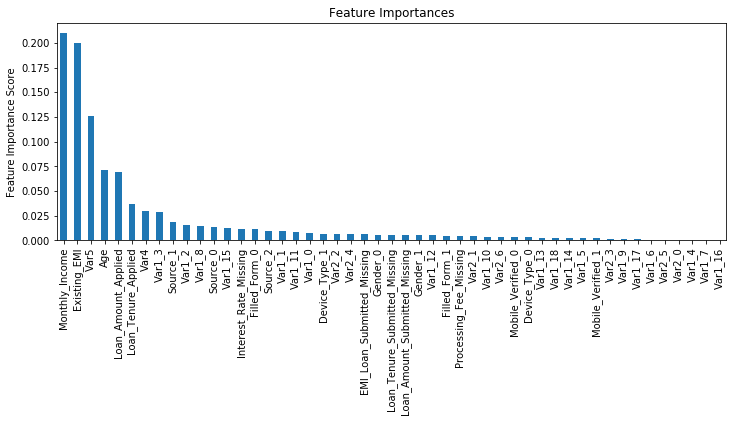

In [71]:
modelfit(gsearch3.best_estimator_, train_x, train_y, test_x, test_y)

In [72]:
##Now lets tune the last tree-parameters, i.e. max_features by trying 7 values from 7 to 19 in steps of 2.

param_test4 = {'max_features':[7,9,11,13,15,17,19]}
gsearch4 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=80,max_depth=7, min_samples_split=1000, min_samples_leaf=70, subsample=0.8, random_state=10),
param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5,verbose=1)
gsearch4.fit(train_x,train_y)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=4)]: Done  35 out of  35 | elapsed:  2.2min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=7,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=70,
              min_samples_split=1000, min_weight_fraction_leaf=0.0,
              n_estimators=80, presort='auto', random_state=10,
              subsample=0.8, verbose=0, warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'max_features': [7, 9, 11, 13, 15, 17, 19]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=1)

In [73]:
print(gsearch4.grid_scores_)
print(gsearch4.best_params_)
print(gsearch4.best_score_)

[mean: 0.84324, std: 0.01326, params: {'max_features': 7}, mean: 0.84216, std: 0.01167, params: {'max_features': 9}, mean: 0.84274, std: 0.01171, params: {'max_features': 11}, mean: 0.84071, std: 0.01290, params: {'max_features': 13}, mean: 0.84094, std: 0.01187, params: {'max_features': 15}, mean: 0.84002, std: 0.01032, params: {'max_features': 17}, mean: 0.84026, std: 0.01429, params: {'max_features': 19}]
{'max_features': 7}
0.8432372923154133


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   26.0s finished



Model Report
Accuracy : 0.9849
AUC Score (Test): 0.829077
CV Score : Mean - 0.8432373 | Std - 0.01325565 | Min - 0.8269087 | Max - 0.8672148


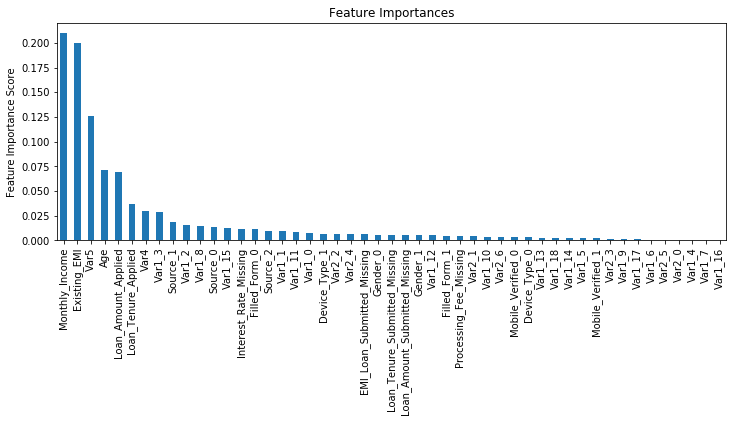

In [74]:
modelfit(gsearch4.best_estimator_, train_x, train_y, test_x, test_y)

In [75]:
## lets try different subsamples
param_test5 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
gsearch5 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, 
           n_estimators=80,max_depth=7,min_samples_split=1000, min_samples_leaf=70, 
           subsample=0.8, random_state=10,max_features=7),
param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(train_x,train_y)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=7,
              max_features=7, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=70,
              min_samples_split=1000, min_weight_fraction_leaf=0.0,
              n_estimators=80, presort='auto', random_state=10,
              subsample=0.8, verbose=0, warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'subsample': [0.6, 0.7, 0.75, 0.8, 0.85, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [76]:
print(gsearch5.grid_scores_)
print(gsearch5.best_params_)
print(gsearch5.best_score_)

[mean: 0.83866, std: 0.01296, params: {'subsample': 0.6}, mean: 0.83830, std: 0.01215, params: {'subsample': 0.7}, mean: 0.84016, std: 0.01031, params: {'subsample': 0.75}, mean: 0.84324, std: 0.01326, params: {'subsample': 0.8}, mean: 0.84232, std: 0.01179, params: {'subsample': 0.85}, mean: 0.84168, std: 0.01271, params: {'subsample': 0.9}]
{'subsample': 0.8}
0.8432372923154133


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   49.9s finished



Model Report
Accuracy : 0.9849
AUC Score (Test): 0.830953
CV Score : Mean - 0.8428108 | Std - 0.01324418 | Min - 0.8266149 | Max - 0.8646197


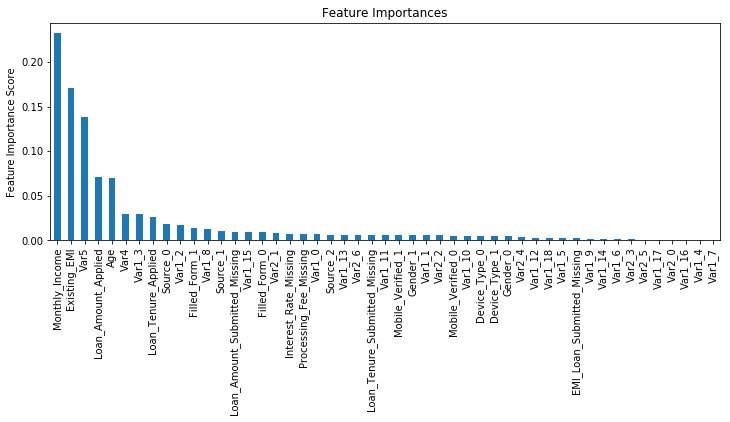

In [77]:
## try with half learning rate and double the estimators
gbm_tuned_1 = GradientBoostingClassifier(learning_rate=0.05, n_estimators=140,
              max_depth=7, min_samples_split=1000,min_samples_leaf=70, subsample=0.8, 
              random_state=10, max_features=7)
modelfit(gbm_tuned_1, train_x, train_y,test_x,test_y)

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.4min finished



Model Report
Accuracy : 0.9849
AUC Score (Test): 0.831968
CV Score : Mean - 0.8438938 | Std - 0.01228762 | Min - 0.8293611 | Max - 0.8642363


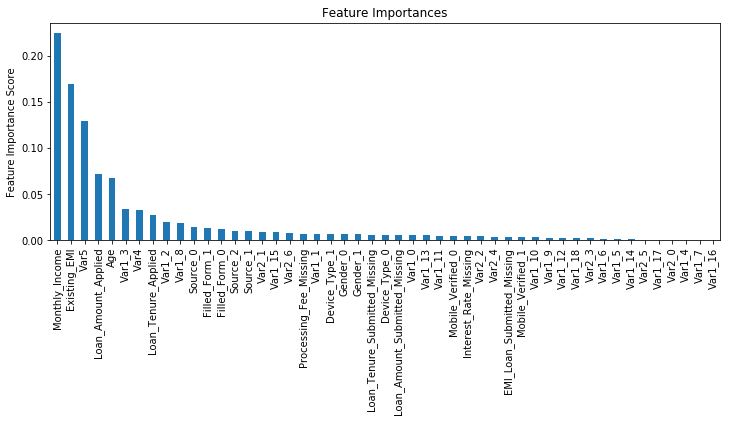

In [78]:
##Now lets reduce to one-tenth of the original value, i.e. 0.01 for 600 trees.
gbm_tuned_2 = GradientBoostingClassifier(learning_rate=0.01, n_estimators=600,
              max_depth=7, min_samples_split=1000,min_samples_leaf=70, subsample=0.8, 
              random_state=10, max_features=7)
modelfit(gbm_tuned_2, train_x, train_y,test_x,test_y)

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  6.5min finished



Model Report
Accuracy : 0.9849
AUC Score (Test): 0.831500
CV Score : Mean - 0.8439155 | Std - 0.01287489 | Min - 0.8282713 | Max - 0.8655863


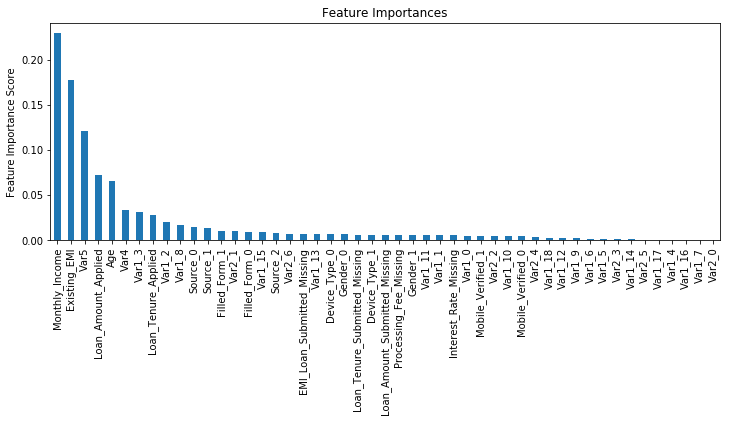

In [79]:
##Now lets reduce to one-twentieth of the original value, i.e. 0.005 for 1200 trees.
gbm_tuned_3 = GradientBoostingClassifier(learning_rate=0.005, n_estimators=1200,
              max_depth=7, min_samples_split=1000,min_samples_leaf=70, subsample=0.8, 
              random_state=10, max_features=7)
modelfit(gbm_tuned_3, train_x, train_y,test_x,test_y)

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  6.5min finished



Model Report
Accuracy : 0.9849
AUC Score (Test): 0.831500
CV Score : Mean - 0.8439155 | Std - 0.01287489 | Min - 0.8282713 | Max - 0.8655863


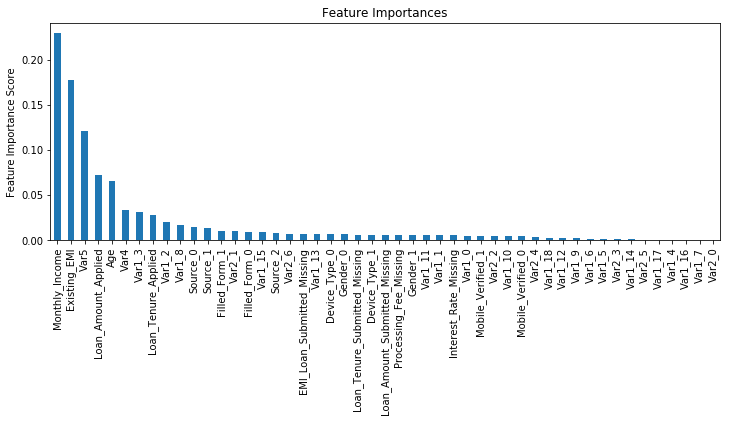

In [80]:
##Now lets reduce to one-twentieth of the original value, i.e. 0.005 for 1500 trees.
gbm_tuned_3 = GradientBoostingClassifier(learning_rate=0.005, n_estimators=1200,
              max_depth=7, min_samples_split=1000,min_samples_leaf=70, subsample=0.8, 
              random_state=10, max_features=7)
modelfit(gbm_tuned_3, train_x, train_y,test_x,test_y)